# Bicicleta de Whipple


Modelo linearizado em torno de uma solução em regime permanente na qual a bicicleta descreve uma translação em linha reta com velocidade \(v\) constante [(Meijaard *et al.*, 2007)](https://dx.doi.org/10.1098/rspa.2007.1857):
\begin{align*}
    M \ddot q = - v C_1 \dot q - (g K_0 + v^2 K_2 ) q + \tau
\end{align*}
com $q = (\phi, \delta) \in \mathbb{R}^2$ e $\tau = (\tau_\phi, \tau_\delta) = (w, u)$.

In [1]:
# !pip install sympy
# !pip install control
# !pip install tbcontrol
# !pip install ipywidgets

In [38]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import control as ct
from scipy.optimize import minimize

In [3]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

## 1. Sistema na forma de espaço de estados

\begin{align*}
    & \dot x = A(v) x + B u + E w \\ 
    & y = C x
\end{align*}

In [4]:
v = sp.symbols('v')

M = sp.Matrix([[80.81722, 2.31941332208709],
              [2.31941332208709, 0.29784188199686]])

K0 = sp.Matrix([[-80.95,-2.59951685249872],
                [-2.59951685249872,-0.80329488458618]])

K2 = sp.Matrix([[0,76.59734589573222],
                [0,2.65431523794604]])

C1 = sp.Matrix([[0,33.86641391492494],
                [-0.85035641456978,1.68540397397560]])

A = sp.Matrix([[sp.zeros(2,2), sp.eye(2)],
               [- M.inv() * (9.81 * K0 + v * v *K2), -M.inv()*(v*C1)]])

Be = sp.Matrix([[sp.zeros(2,2)],
               [M.inv()]])

B = Be[:, 1]
E = Be[:, 0]

C_φ = sp.Matrix([[1, 0, 0, 0]])
C_δ = sp.Matrix([[0, 1, 0, 0]])

An = sp.lambdify((v), A)
Bn = np.array(B)
En = np.array(E)

## 2. Função de transferência em malha aberta

### 2.1. Forma de espaço de estados (original)

In [5]:
bike_ss = ct.ss(An(6), B, C_φ, 0)
bike_ss

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

### 2.2. Função de transferência (original)

In [6]:
G_p0 = ct.tf(bike_ss)

# elimina, se aparecer, um termo efetivamente nulo (< 1e-10 * s^3) no numerador
if (np.abs(G_p0.num[0][0][0]) < 1e-10):
    G_p = ct.tf(G_p0.num[0][0][1:], G_p0.den[0][0])
else:
    G_p = G_p0

G_p    

TransferFunction(array([-1.24092025e-01, -1.08714178e+01, -1.46166191e+02]), array([  1.        ,  19.14232786,  86.05069461, 593.3528833 ,
         2.41168533]))

In [7]:
G_p.poles()

array([-1.60853712e+01+0.j        , -1.52644487e+00+5.87673061j,
       -1.52644487e+00-5.87673061j, -4.06690077e-03+0.j        ])

In [8]:
G_p.zeros()

array([-71.02318781+0.j, -16.58451952+0.j])

In [9]:
G_p.dcgain()

-60.60748823687449

### 2.3. Função de transferência de ordem reduzida (via função `balred`)

Baseada no algoritmo de decomposição em valores singulares (SVD) de Hankel.

In [176]:
G_pr = ct.tf(ct.balred(bike_ss, 3))
G_pr

TransferFunction(array([-4.38276249e-04, -1.13020562e-01, -9.08653001e+00]), array([ 1.        ,  3.06120171, 36.87697061,  0.14992415]))

In [177]:
G_pr.poles()

array([-1.52856741+5.87605473j, -1.52856741-5.87605473j,
       -0.00406689+0.j        ])

In [178]:
G_pr.zeros()

array([-128.93758442+64.08998019j, -128.93758442-64.08998019j])

In [179]:
G_pr.dcgain()

-60.60751549097244

### 2.4. Função de transferência de ordem reduzida (via truncamento)

In [180]:
s = ct.tf([1, 0],[1])
G_pt = G_p.dcgain() * (1 - s/G_p.zeros()[1])/((1 - s/G_p.poles()[1])*
                               (1 - s/G_p.poles()[2])*(1 - s/G_p.poles()[3]))
G_pt

TransferFunction(array([  -9.08690191+0.j, -150.70190205+0.j]), array([ 16.58451952+0.j,  50.69815694+0.j, 611.61074936+0.j,
         2.48652281+0.j]))

In [199]:
G_pt.poles()

array([-1.52644487+5.87673061j, -1.52644487-5.87673061j,
       -0.0040669 +0.j        ])

In [182]:
G_pt.zeros()

array([-16.58451952-0.j])

In [183]:
G_pt.dcgain()

-60.607488236874495

### 2.5. Comparação dos diagramas de Bode (original vs. reduzidos)

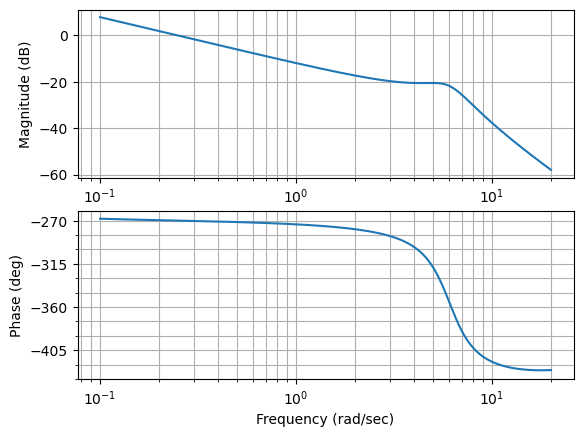

In [184]:
mag, phase, omega = ct.bode(G_p, dB=True, omega_limits=(0.1, 20))

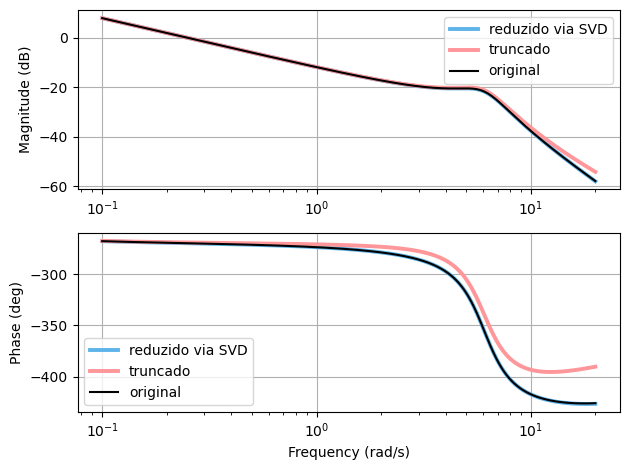

In [185]:
plt.figure()
plt.subplot(2, 1, 1)

mag_pr, phase_pr, omega_pr = ct.bode(
    G_pr, dB=True, omega_limits=(0.1, 20), plot=False)
mag_pt, phase_pt, omega_pt = ct.bode(
    G_pt, dB=True, omega_limits=(0.1, 20), plot=False)


plt.semilogx(omega_pr, 20 * np.log10(mag_pr), 
             label='reduzido via SVD', color=cp['lblue'], linewidth=2.8)
plt.semilogx(omega_pt, 20 * np.log10(mag_pt), 
             label='truncado', color=cp['lred'], linewidth=2.8)
plt.semilogx(omega, 20 * np.log10(mag), 
             label='original', color='black', linewidth=1.5)
plt.ylabel('Magnitude (dB)')

# plt.title('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(omega_pr, phase_pr * (180.0 / np.pi),
             label='reduzido via SVD', color=cp['lblue'], linewidth=2.8)
plt.semilogx(omega_pt, phase_pt * (180.0 / np.pi),
             label='truncado', color=cp['lred'], linewidth=2.8)
plt.semilogx(omega, phase * (180.0 / np.pi),
             label='original', color='black', linewidth=1.5)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (rad/s)')
# plt.title('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## 3. Sintonia de controlador PID ótimo 

Cenário: resposta a degrau em malha fechada via minimização do ITAE

In [186]:
# Função objetivo ITAE
def ITAE(params, G_p):
    Kp, Ki, Kd = params
    C = ct.tf([Kd, Kp, Ki], [1, 0])
    G_cl = ct.feedback(C * G_p, 1)
    t, y = ct.step_response(G_cl)
    itae = np.trapz(t * np.abs(1 - y), t)
    return itae

In [187]:
# Estimativas iniciais para Kp, Ki e Kd
initial_params = [-2, -0.2, 0]

# Otimização
result = minimize(ITAE, initial_params, args=(G_p,), method='Nelder-Mead')
Kp, Ki, Kd = result.x

In [188]:
[Kp, Ki, Kd]

[-10.45371170075392, -16.885061227186824, -1.4493988912875482]

In [189]:
ITAE([Kp, Ki, Kd], G_p)

0.8145408246565922

In [190]:
# Controlador PID com parâmetros otimizados
s = ct.tf([1, 0], [1])
τ_d = Kd/Kp
N_d = 10000
G_c = Ki/s + Kp * (1 + (τ_d * s)/((τ_d * s)/N_d + 1))

# Função de transferência em malha fechada com controlador otimizado
T = ct.feedback(G_c * G_p, 1)
T

TransferFunction(array([1.79876830e+03, 1.70558480e+05, 3.27618814e+06, 1.71157799e+07,
       2.46802508e+07]), array([1.38649212e-01, 1.00026541e+04, 1.93233978e+05, 1.03114769e+06,
       9.20971731e+06, 1.71398968e+07, 2.46802508e+07]))

In [191]:
T.poles()

array([-7.21242835e+04+0.j        , -1.60970244e+01+0.j        ,
       -5.88565357e-01+6.71233722j, -5.88565357e-01-6.71233722j,
       -1.02393067e+00+1.52596434j, -1.02393067e+00-1.52596434j])

In [192]:
# síntese de um pré-filtro
G_f = ct.tf([Ki], [Kd, Kp, Ki])
G_f

TransferFunction(array([-16.88506123]), array([ -1.44939889, -10.4537117 , -16.88506123]))

In [193]:
# Função de transferência em malha fechada com controlador otimizado e pré-filtro
T_f = ct.series(G_f, T)
T_f

TransferFunction(array([-3.03723129e+04, -2.87989037e+06, -5.53186374e+07, -2.89000992e+08,
       -4.16727545e+08]), array([-2.00958014e-01, -1.44992851e+04, -3.84640316e+05, -3.68345205e+06,
       -2.73906423e+07, -1.38529269e+08, -3.70453708e+08, -5.47408432e+08,
       -4.16727545e+08]))

In [194]:
T_f.poles()

array([-7.21242835e+04+0.j        , -1.60970244e+01+0.j        ,
       -5.88565357e-01+6.71233722j, -5.88565357e-01-6.71233722j,
       -4.77033063e+00+0.j        , -2.44211569e+00+0.j        ,
       -1.02393067e+00+1.52596434j, -1.02393067e+00-1.52596434j])

In [195]:
# FTs entre referência e entrada de controle (torque τ_δ)
Frτ = ct.feedback(G_c, G_p)
Frτ_f = ct.series(G_f, Frτ)

### 3.1. Simulação de resposta a degrau

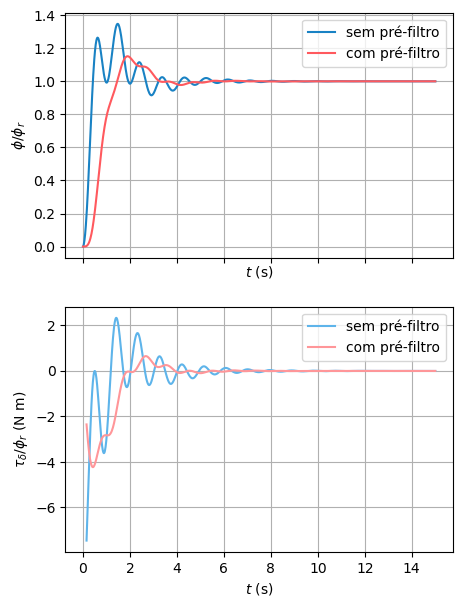

In [196]:
ts = np.linspace(0, 15, 1000)

t, y = ct.step_response(T, ts)
t, u = ct.step_response(Frτ, ts)

t, y_f = ct.step_response(T_f, ts)
t, u_f = ct.step_response(Frτ_f, ts)


fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, y, color=cp['blue'], label='sem pré-filtro')
state.plot(t, y_f, color=cp['red'], label='com pré-filtro')
state.set_ylabel(r'$\phi / \phi_r$ ')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u[10:], color=cp['lblue'],
                   label='sem pré-filtro')
control_input.plot(t[10:], u_f[10:], color=cp['lred'],
                   label='com pré-filtro')
control_input.set_ylabel(r'$\tau_\delta/\phi_r$ (N m)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

### 3.2. Diagramas de Bode do sistema em malha fechada

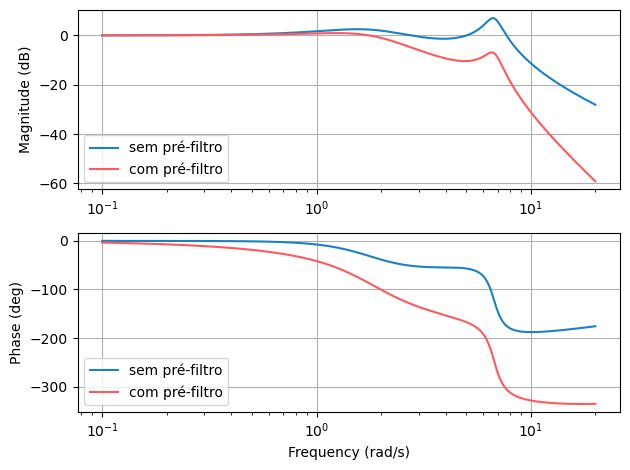

In [197]:
plt.figure()
plt.subplot(2, 1, 1)

mag_T, phase_T, omega_T = ct.bode(
    T, dB=True, omega_limits=(0.1, 20), plot=False)
mag_T_f, phase_T_f, omega_T_f = ct.bode(
    T_f, dB=True, omega_limits=(0.1, 20), plot=False)


plt.semilogx(omega_T, 20 * np.log10(mag_T),
             label='sem pré-filtro', color=cp['blue'], linewidth=1.5)
plt.semilogx(omega_T_f, 20 * np.log10(mag_T_f),
             label='com pré-filtro', color=cp['red'], linewidth=1.5)
plt.ylabel('Magnitude (dB)')

# plt.title('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(omega_T, phase_T * (180.0 / np.pi),
             label='sem pré-filtro', color=cp['blue'], linewidth=1.5)
plt.semilogx(omega_T_f, phase_T_f * (180.0 / np.pi),
             label='com pré-filtro', color=cp['red'], linewidth=1.5)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (rad/s)')
# plt.title('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()